### Загрузка бибилиотек

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

### Очистка данных

In [97]:
# Загрузка данных из CSV файлов
df1 = pd.read_csv('sales_inventory_orders_data.csv')
df2 = pd.read_csv('broken_sales.csv')

# Объединение датафреймов
data = pd.concat([df1, df2], ignore_index=True)

In [98]:
# Пример: Удаление дубликатов
data.drop_duplicates(inplace=True)

In [99]:
# Пример: Преобразование формата даты
data['Date'] = pd.to_datetime(data['Date'])

In [100]:
# Очистка и обработка пропущенных значений
data.dropna(subset=['Sales'], inplace=True)

In [101]:
# Создание сводных таблиц
# Total Price = Sales * Sale Price
data['TotalPrice'] = data['Sales'] * data['SalePrice']

In [102]:
data.shape

(3285, 11)

In [103]:
data.head()

,Date,Product,Sales,Orders,Inventory,UnrealizedDemand,DeliveryTime,DeliveryPrice,StoragePrice,SalePrice,TotalPrice
0,2023-01-01,Product_1,22.0,120,84,0,2,4.45,0.29,20,440.0
1,2023-01-02,Product_1,17.0,0,67,0,0,0.00,0.29,20,340.0
2,2023-01-03,Product_1,15.0,0,172,0,0,0.00,0.29,20,300.0
3,2023-01-04,Product_1,19.0,0,153,0,0,0.00,0.29,20,380.0
4,2023-01-05,Product_1,17.0,0,136,0,0,0.00,0.29,20,340.0


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3285 entries, 0 to 3284
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              3285 non-null   datetime64[ns]
 1   Product           3285 non-null   object        
 2   Sales             3285 non-null   float64       
 3   Orders            3285 non-null   int64         
 4   Inventory         3285 non-null   int64         
 5   UnrealizedDemand  3285 non-null   int64         
 6   DeliveryTime      3285 non-null   int64         
 7   DeliveryPrice     3285 non-null   float64       
 8   StoragePrice      3285 non-null   float64       
 9   SalePrice         3285 non-null   int64         
 10  TotalPrice        3285 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 308.0+ KB


In [105]:
# Ежемесячные продажи для каждого продукта
monthly_sales = data.groupby(['Product', data['Date'].dt.to_period("M")])['Sales'].sum().reset_index()

# Ежемесячная выручка для каждого продукта
monthly_revenue = data.groupby(['Product', data['Date'].dt.to_period("M")])['TotalPrice'].sum().reset_index()


In [11]:
monthly_sales

,Product,Date,Sales
0,Product_1,2023-01,563.0
1,Product_1,2023-02,565.0
2,Product_1,2023-03,637.0
3,Product_1,2023-04,684.0
4,Product_1,2023-05,677.0
...,...,...,...
103,Product_9,2023-08,775.0
104,Product_9,2023-09,734.0
105,Product_9,2023-10,743.0
106,Product_9,2023-11,808.0


In [12]:
monthly_revenue

,Product,Date,TotalPrice
0,Product_1,2023-01,11260.0
1,Product_1,2023-02,11300.0
2,Product_1,2023-03,12740.0
3,Product_1,2023-04,13680.0
4,Product_1,2023-05,13540.0
...,...,...,...
103,Product_9,2023-08,62775.0
104,Product_9,2023-09,59454.0
105,Product_9,2023-10,60183.0
106,Product_9,2023-11,65448.0


### Анализ ключевых метрик

In [26]:
# Оборачиваемость запасов = Сумма продаж / Средний уровень инвентаря
inventory_turnover = data.groupby('Product').apply(lambda x: x['Sales'].sum() / x['Inventory'].mean()).reset_index()
inventory_turnover.columns = ['Product', 'InventoryTurnover']
inventory_turnover

,Product,InventoryTurnover
0,Product_1,70.023793
1,Product_2,51.873191
2,Product_3,81.432300
3,Product_4,61.346850
4,Product_5,94.653961
5,Product_6,85.312442
6,Product_7,57.940215
7,Product_8,85.703195
8,Product_9,134.054054


In [37]:
# Уровень сервиса = (Сумма продаж) / (Сумма продаж + Невыполненный спрос) * 100
service_level = data.groupby('Product').apply(lambda x: (x['Sales'].sum() / (x['Sales'].sum() + x['UnrealizedDemand'].sum())) * 100).reset_index()
service_level.columns = ['Product', 'ServiceLevel']
service_level

,Product,ServiceLevel
0,Product_1,100.000000
1,Product_2,100.000000
2,Product_3,89.034553
3,Product_4,100.000000
4,Product_5,93.568660
5,Product_6,95.113588
6,Product_7,100.000000
7,Product_8,98.351952
8,Product_9,57.678610


In [34]:
# Дни запасов = Средний уровень инвентаря / (Сумма продаж / 365)
days_inventory = data.groupby('Product').apply(lambda x: x['Inventory'].mean() / (x['Sales'].sum() / 365)).reset_index()
days_inventory.columns = ['Product', 'DaysInventory']
days_inventory

,Product,DaysInventory
0,Product_1,5.212514
1,Product_2,7.036390
2,Product_3,4.482251
3,Product_4,5.949776
4,Product_5,3.856151
5,Product_6,4.278391
6,Product_7,6.299597
7,Product_8,4.258884
8,Product_9,2.722782


In [31]:
# Затраты на хранение = Средняя стоимость хранения * Средний уровень инвентаря
storage_costs = data.groupby('Product').apply(lambda x: x['StoragePrice'].mean() * x['Inventory'].mean()).reset_index()
storage_costs.columns = ['Product', 'StorageCosts']
storage_costs

,Product,StorageCosts
0,Product_1,37.065973
1,Product_2,46.772137
2,Product_3,54.869014
3,Product_4,61.069151
4,Product_5,72.669014
5,Product_6,98.839041
6,Product_7,66.288329
7,Product_8,20.750685
8,Product_9,37.296000


In [33]:
# Объем заказов = Сумма заказов / Количество заказов
order_volume = data.groupby('Product').apply(lambda x: x['Orders'].sum() / x['Orders'].count()).reset_index()
order_volume.columns = ['Product', 'OrderVolume']
order_volume

,Product,OrderVolume
0,Product_1,24.849315
1,Product_2,24.575342
2,Product_3,24.054795
3,Product_4,24.520548
4,Product_5,24.438356
5,Product_6,24.438356
6,Product_7,25.068493
7,Product_8,24.602740
8,Product_9,21.671233


In [21]:
# Описательная статистика для одного продукта (пример для первого продукта)
product_stats = data[data['Product'] == 'Product_9']['Sales'].describe()
print(product_stats)

count    365.000000
mean      21.742466
std        7.960029
min        0.000000
25%       19.000000
50%       23.000000
75%       27.000000
max       39.000000
Name: Sales, dtype: float64


### Анализ ключевых показателей и трендов

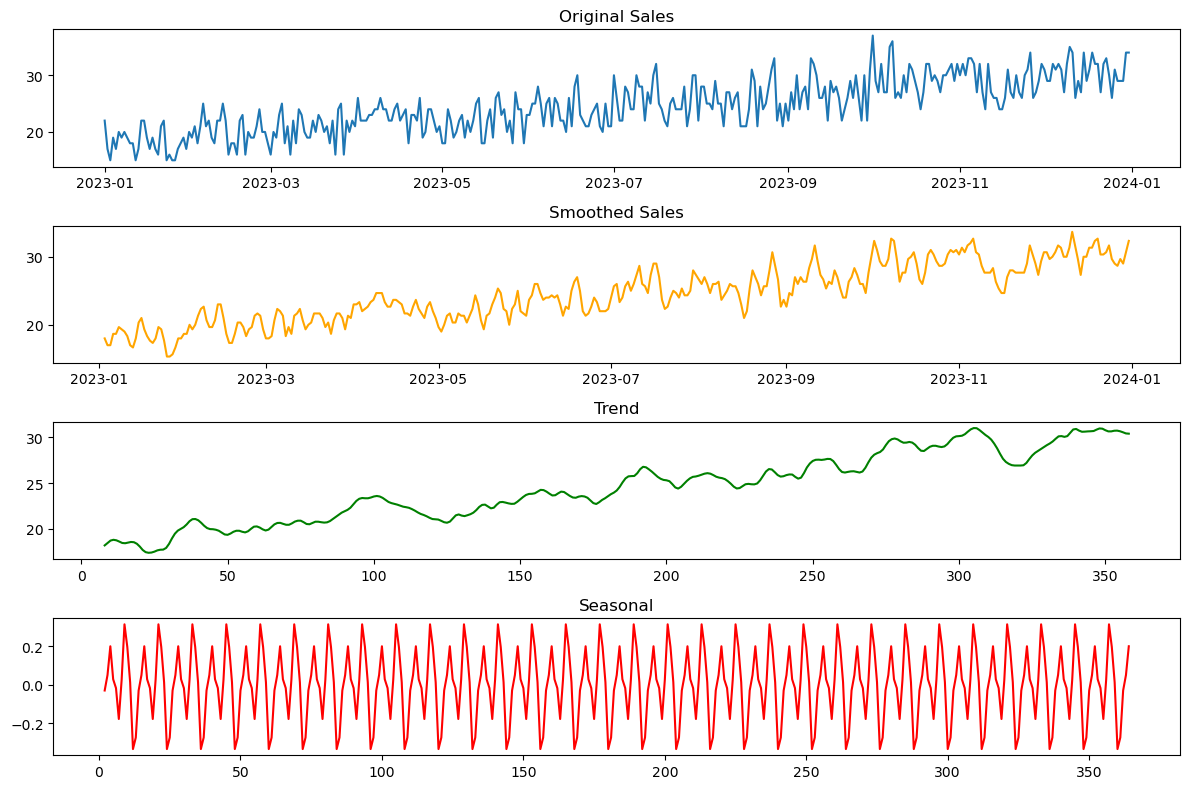

In [38]:
# Отфильтровываем данные для одного продукта (пример для первого продукта)
product_data = data[data['Product'] == 'Product_1'].copy()

# Сглаживание временного ряда с использованием скользящего среднего
window_size = 3  # Размер окна для скользящего среднего
product_data['Sales_smoothed'] = product_data['Sales'].rolling(window=window_size).mean()

# Декомпозиция временного ряда
result = seasonal_decompose(product_data['Sales_smoothed'].dropna(), model='additive', period=12)

# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(product_data['Date'], product_data['Sales'], label='Original Sales')
plt.title('Original Sales')

plt.subplot(4, 1, 2)
plt.plot(product_data['Date'], product_data['Sales_smoothed'], label=f'Smoothed Sales (Window Size={window_size})', color='orange')
plt.title('Smoothed Sales')

plt.subplot(4, 1, 3)
result.trend.dropna().plot(label='Trend', color='green')
plt.title('Trend')

plt.subplot(4, 1, 4)
result.seasonal.dropna().plot(label='Seasonal', color='red')
plt.title('Seasonal')

plt.tight_layout()
plt.show()

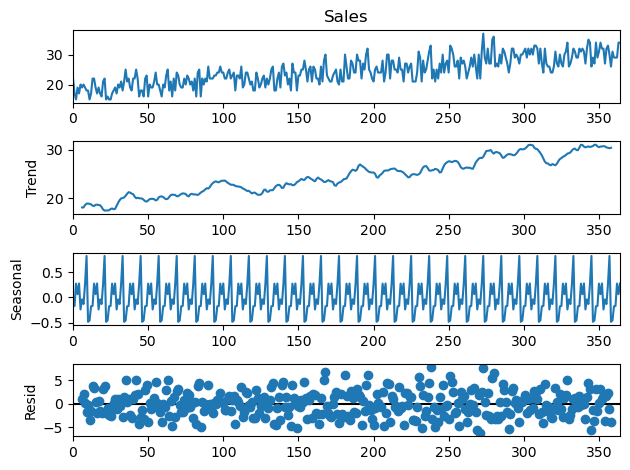

In [15]:
# Декомпозиция временного ряда для одного продукта (пример для первого продукта)
result = seasonal_decompose(data[data['Product'] == 'Product_1']['Sales'], model='additive', period=12)
result.plot()
plt.show()

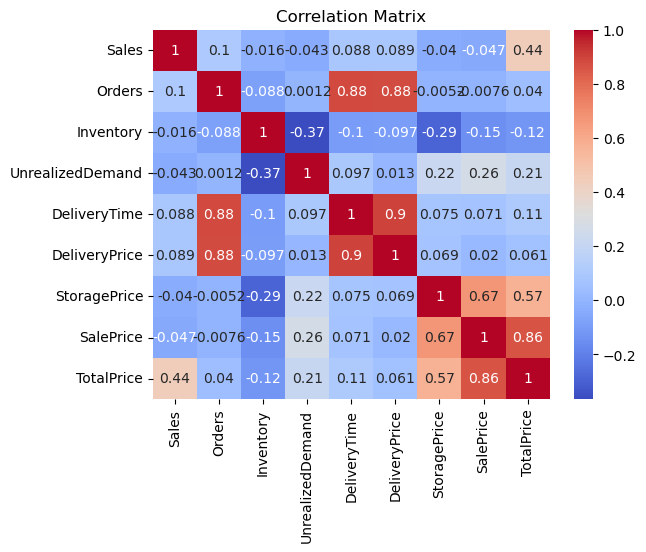

In [16]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

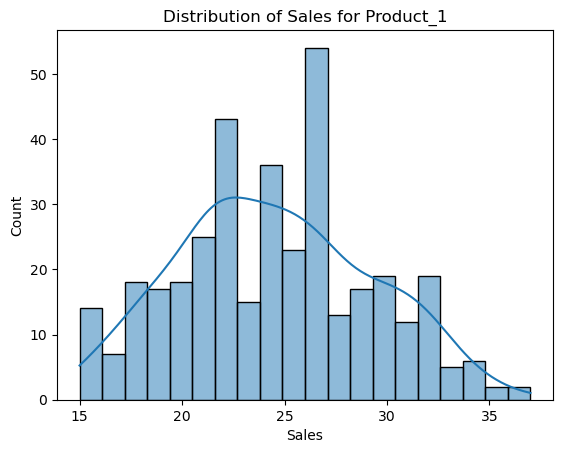

In [17]:
# Гистограмма распределения продаж для одного продукта (пример для первого продукта)
sns.histplot(data[data['Product'] == 'Product_1']['Sales'], bins=20, kde=True)
plt.title('Distribution of Sales for Product_1')
plt.show()

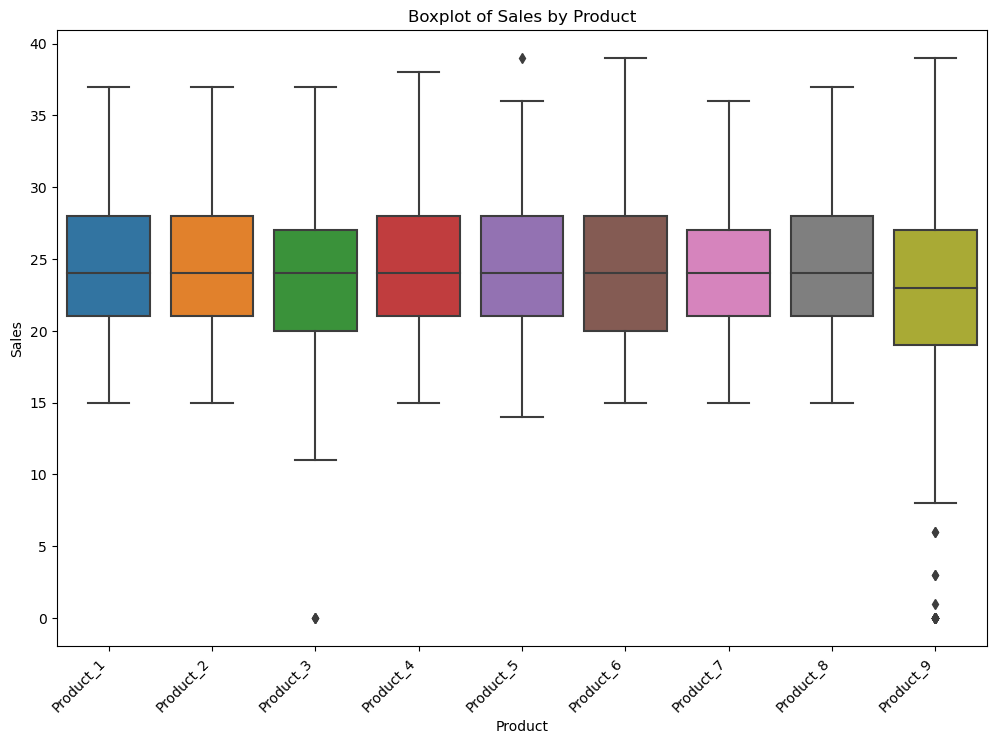

In [23]:
# Уменьшаем количество уникальных значений, отображаемых на графике
top_products = data['Product'].value_counts().head(10).index
filtered_data = data[data['Product'].isin(top_products)]

# Увеличиваем размер графика
plt.figure(figsize=(12, 8))

# Создаем boxplot
sns.boxplot(x='Product', y='Sales', data=filtered_data)
plt.title('Boxplot of Sales by Product')
plt.xticks(rotation=45, ha='right')  # Поворачиваем названия продуктов для лучшей читаемости
plt.show()

### Модели оптимизации 

#### Модель экономического заказа (EOQ)

In [59]:
# Рассчет EOQ для каждого продукта
def calculate_eoq(group):
    D = group['Sales'].sum()  # Годовой объем продаж
    S = group['DeliveryPrice'].mean() if group['Orders'].sum() > 0 else 100  # Используем среднее значение, если есть заказы, иначе устанавливаем фиксированное значение 100
    H = group['StoragePrice'].iloc[0]  # Стоимость хранения одной единицы продукции в течение года (пример: цена хранения)
    
    return pd.Series({'EOQ': np.sqrt((2 * D * S) / H)})

# Применение функции к каждой группе продуктов
eoq_data = data.groupby('Product').apply(calculate_eoq).reset_index()

# Вывод рассчитанных значений EOQ
eoq_data

,Product,EOQ
0,Product_1,234.381063
1,Product_2,196.099863
2,Product_3,217.575390
3,Product_4,292.838167
4,Product_5,190.688139
5,Product_6,152.916619
6,Product_7,193.896315
7,Product_8,272.049029
8,Product_9,161.526960


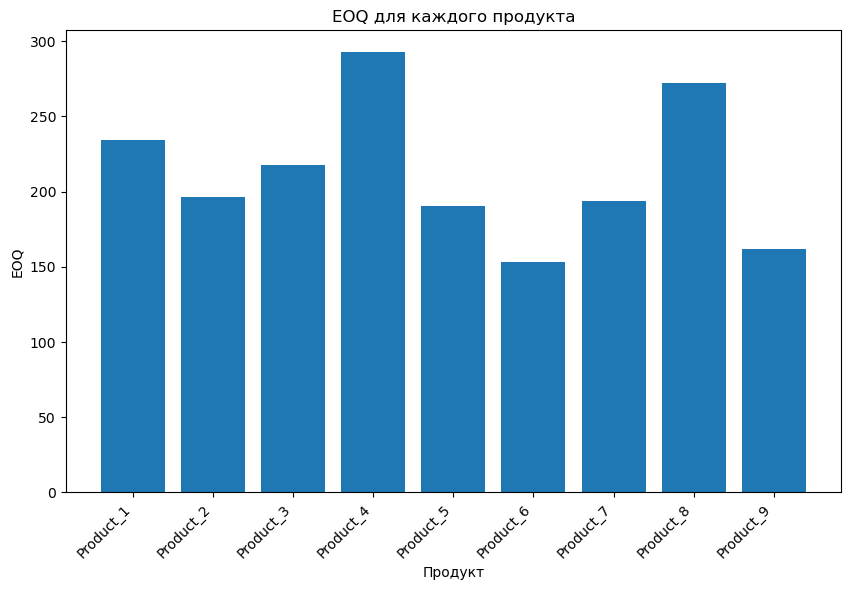

In [49]:
# Визуализация EOQ
plt.figure(figsize=(10, 6))
plt.bar(eoq_data['Product'], eoq_data['EOQ'])
plt.xlabel('Продукт')
plt.ylabel('EOQ')
plt.title('EOQ для каждого продукта')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\danym\AppData\Local\Temp\ipykernel_18552\90192945.py:10: RuntimeWarning: divide by zero encountered in true_divide
  order_costs = product_data['DeliveryPrice'].iloc[0] * product_data['Sales'].sum() / order_quantities  # Пример: Издержки размещения заказа = DeliveryPrice * D / order_quantity


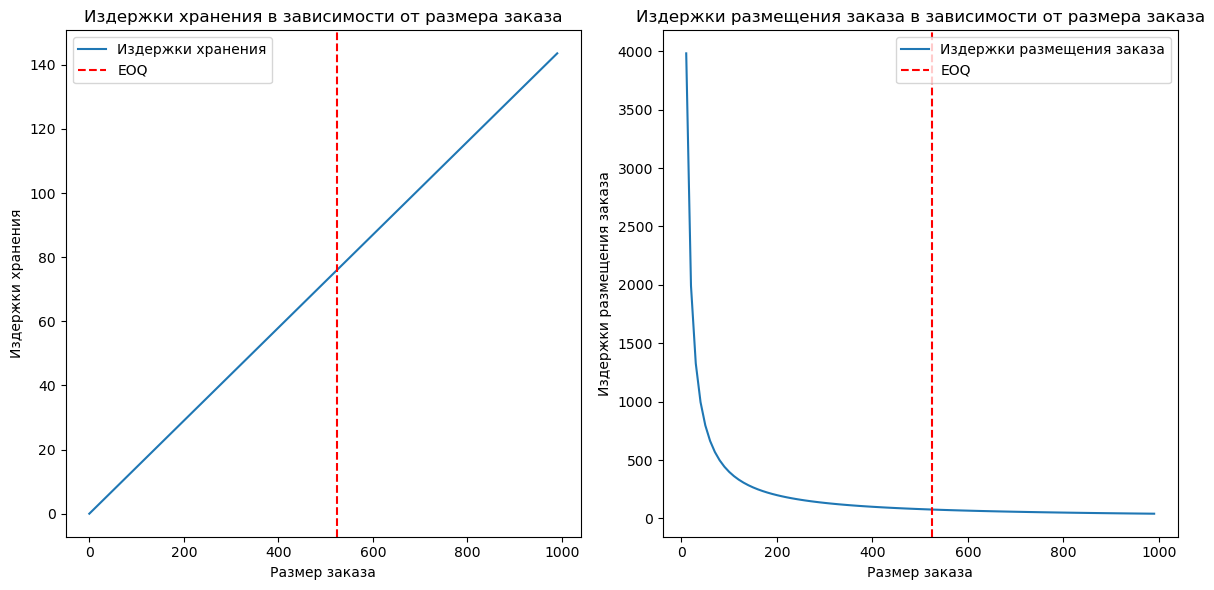

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Выберем один продукт (например, 'Product_1') для визуализации
product_data = data[data['Product'] == 'Product_1']

# Рассчет издержек хранения и размещения заказа для различных размеров заказа
order_quantities = np.arange(0, 1000, 10)
storage_costs = product_data['StoragePrice'].iloc[0] * order_quantities / 2  # Пример: Издержки хранения = StoragePrice * order_quantity / 2
order_costs = product_data['DeliveryPrice'].iloc[0] * product_data['Sales'].sum() / order_quantities  # Пример: Издержки размещения заказа = DeliveryPrice * D / order_quantity

# Рассчет EOQ для точки пересечения минимума издержек
D = product_data['Sales'].sum()
S = product_data['DeliveryPrice'].iloc[0]
H = product_data['StoragePrice'].iloc[0]
eoq = np.sqrt((2 * D * S) / H)

# Визуализация
plt.figure(figsize=(12, 6))

# График издержек хранения
plt.subplot(1, 2, 1)
plt.plot(order_quantities, storage_costs, label='Издержки хранения')
plt.axvline(x=eoq, color='r', linestyle='--', label='EOQ')
plt.xlabel('Размер заказа')
plt.ylabel('Издержки хранения')
plt.title('Издержки хранения в зависимости от размера заказа')
plt.legend()

# График издержек размещения заказа
plt.subplot(1, 2, 2)
plt.plot(order_quantities, order_costs, label='Издержки размещения заказа')
plt.axvline(x=eoq, color='r', linestyle='--', label='EOQ')
plt.xlabel('Размер заказа')
plt.ylabel('Издержки размещения заказа')
plt.title('Издержки размещения заказа в зависимости от размера заказа')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\danym\AppData\Local\Temp\ipykernel_18552\2025423416.py:18: RuntimeWarning: divide by zero encountered in true_divide
  order_costs = order_costs * D / order_quantities


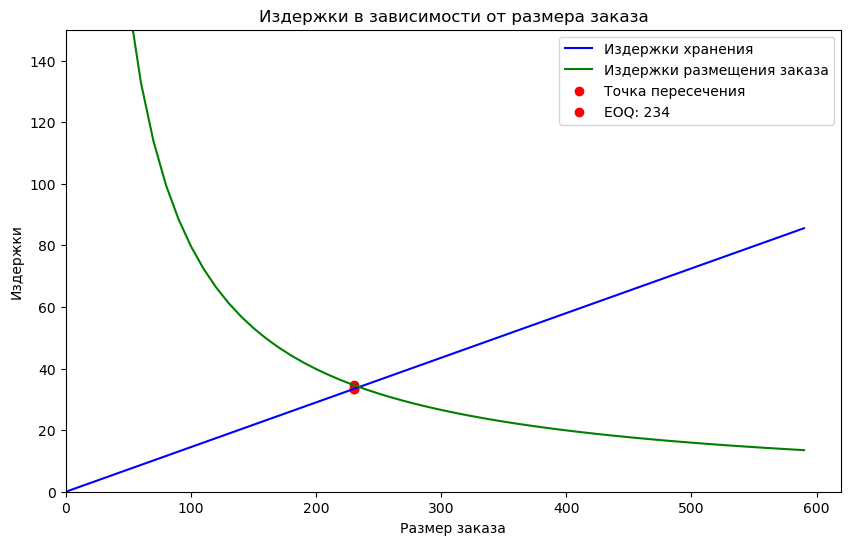

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Выберем один продукт (например, 'Product_1') для визуализации
product_data = data[data['Product'] == 'Product_1']

# Рассчет издержек хранения и размещения заказа для различных размеров заказа
order_quantities = np.arange(0, 600, 10)

# Годовой объем продаж для конкретного продукта (например, 'Product_1')
D = product_data['Sales'].sum()

# Издержки хранения для каждого размера заказа
storage_costs = product_data['StoragePrice'].iloc[0] * order_quantities / 2

# Издержки размещения заказа для каждого размера заказа
order_costs = product_data['DeliveryPrice'].mean() if product_data['Orders'].sum() > 0 else 100
order_costs = order_costs * D / order_quantities

# Визуализация
plt.figure(figsize=(10, 6))

# График издержек хранения
plt.plot(order_quantities, storage_costs, label='Издержки хранения', color='blue')

# График издержек размещения заказа
plt.plot(order_quantities, order_costs, label='Издержки размещения заказа', color='green')

# Находим точку пересечения линий
idx_eoq = np.argmin(np.abs(storage_costs - order_costs))
eoq_quantity = order_quantities[idx_eoq]
eoq_storage_cost = storage_costs[idx_eoq]
eoq_order_cost = order_costs[idx_eoq]

# Отмечаем точку пересечения и EOQ на графике
plt.scatter(eoq_quantity, eoq_storage_cost, color='red', marker='o', label='Точка пересечения')
plt.scatter(eoq_quantity, eoq_order_cost, color='red', marker='o')
plt.scatter(eoq_quantity, eoq_storage_cost, color='red', marker='o', label=f'EOQ: {int(eoq)}')

# Задаем верхнюю границу для линии издержек хранения
plt.ylim(top=150)

# Задаем начальные значения для оси x и y
plt.xlim(left=0)
plt.ylim(bottom=0)

# Настройка оформления графика
plt.xlabel('Размер заказа')
plt.title('Издержки в зависимости от размера заказа')
plt.ylabel('Издержки')
plt.legend()

plt.show()


In [ ]:
#### rop

In [80]:
import numpy as np

# Уровень сервиса (например, 90%)
service_level = 0.9

# Рассчитываем Z-значение для уровня сервиса
Z_value = -1.28  # Для уровня сервиса 90%

# Группируем данные по продуктам
grouped_data = data.groupby('Product')

# Функция для расчета ROP для каждого продукта
def calculate_rop(group):
    # Средний спрос за период ожидания
    mean_demand = group['Sales'].mean()
    
    # Стандартное отклонение спроса
    demand_std = group['Sales'].std()
    
    # Время выполнения заказа (Lead Time)
    lead_time = group['DeliveryTime'].mean()
    
    # Рассчитываем уровень заказа (Reorder Point)
    rop = (mean_demand * lead_time) + (Z_value * demand_std)
    
    return pd.Series({'ROP': rop})

# Применяем функцию к каждой группе продуктов
rop_data = grouped_data.apply(calculate_rop).reset_index()

# Выводим рассчитанные значения ROP
print(rop_data)


     Product        ROP
0  Product_1   3.787606
1  Product_2   3.619268
2  Product_3  10.386406
3  Product_4   4.161375
4  Product_5   7.538046
5  Product_6  10.633361
6  Product_7   2.922422
7  Product_8   7.685493
8  Product_9   8.575208


In [83]:
import pandas as pd
import numpy as np

# Уровень сервиса (например, 90%)
service_level = 0.9

# Рассчитываем Z-значение для уровня сервиса
Z_value = -1.28  # Для уровня сервиса 90%

# Группируем данные по продуктам
grouped_data = data.groupby('Product')

# Функция для расчета ROP для каждого продукта
def calculate_rop(group):
    # Средний спрос за период ожидания
    mean_demand = group['Sales'].mean()
    
    # Стандартное отклонение спроса
    demand_std = group['Sales'].std()
    
    # Время выполнения заказа (Lead Time) - используем первое вхождение
    lead_time = group['DeliveryTime'].loc[group['DeliveryTime'].first_valid_index()]
    
    # Рассчитываем уровень заказа (Reorder Point)
    rop = (mean_demand * lead_time) + (Z_value * demand_std)
    
    print(f"Product: {group['Product'].iloc[0]}, Mean Demand: {mean_demand:.2f}, Demand Std: {demand_std:.2f}, Lead Time: {lead_time:.2f}, ROP: {rop:.2f}")
    
    return pd.Series({'ROP': rop})

# Применяем функцию к каждой группе продуктов
rop_data = grouped_data.apply(calculate_rop).reset_index()

# Выводим рассчитанные значения ROP
print(rop_data)


Product: Product_1, Mean Demand: 24.52, Demand Std: 4.70, Lead Time: 2.00, ROP: 43.02
Product: Product_2, Mean Demand: 24.62, Demand Std: 4.66, Lead Time: 0.00, ROP: -5.96
Product: Product_3, Mean Demand: 24.00, Demand Std: 5.45, Lead Time: 0.00, ROP: -6.97
Product: Product_4, Mean Demand: 24.44, Demand Std: 4.80, Lead Time: 2.00, ROP: 42.73
Product: Product_5, Mean Demand: 24.47, Demand Std: 4.95, Lead Time: 0.00, ROP: -6.34
Product: Product_6, Mean Demand: 24.32, Demand Std: 4.81, Lead Time: 4.00, ROP: 91.12
Product: Product_7, Mean Demand: 24.47, Demand Std: 4.74, Lead Time: 2.00, ROP: 42.88
Product: Product_8, Mean Demand: 24.36, Demand Std: 4.95, Lead Time: 0.00, ROP: -6.33
Product: Product_9, Mean Demand: 21.74, Demand Std: 7.96, Lead Time: 0.00, ROP: -10.19
     Product        ROP
0  Product_1  43.020483
1  Product_2  -5.958604
2  Product_3  -6.974479
3  Product_4  42.727109
4  Product_5  -6.341714
5  Product_6  91.115312
6  Product_7  42.880928
7  Product_8  -6.330795
8  Produc

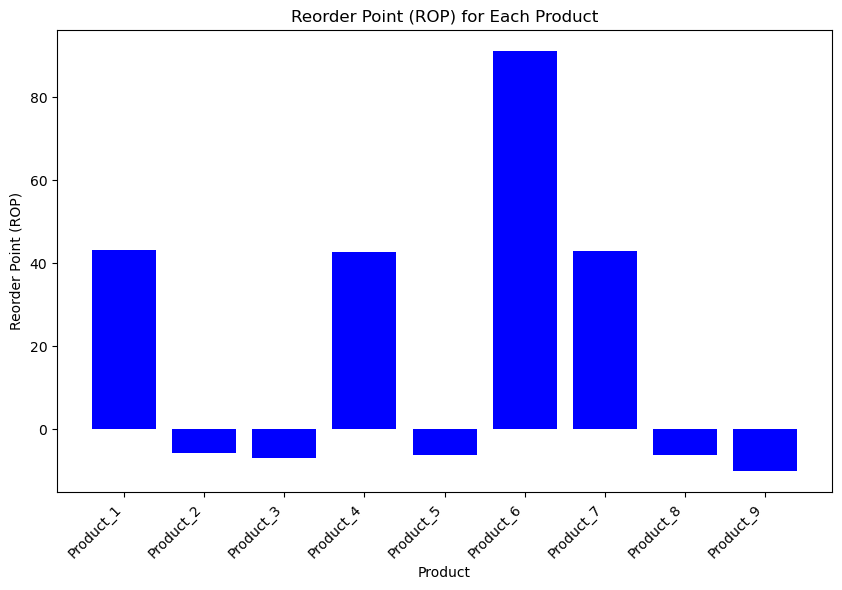

In [84]:
# График ROP для каждого продукта
plt.figure(figsize=(10, 6))
plt.bar(rop_data['Product'], rop_data['ROP'], color='blue')
plt.xlabel('Product')
plt.ylabel('Reorder Point (ROP)')
plt.title('Reorder Point (ROP) for Each Product')
plt.xticks(rotation=45, ha='right')
plt.show()

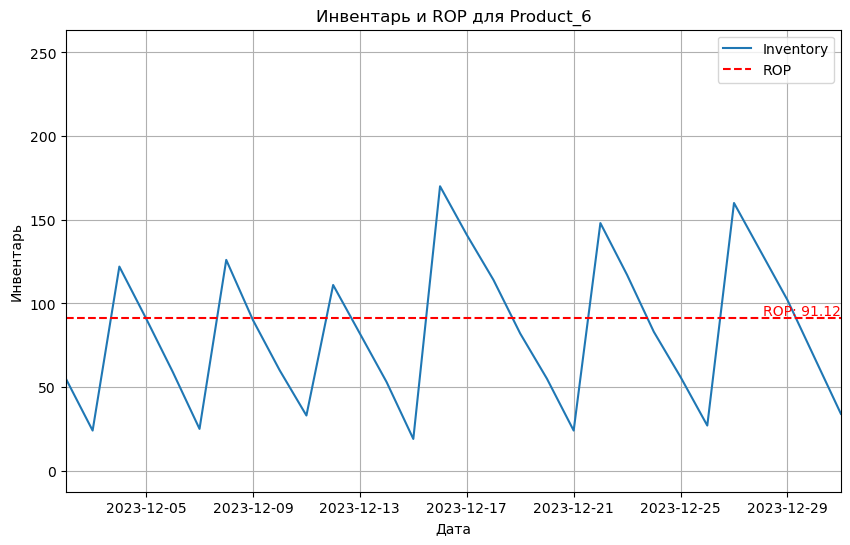

In [93]:
import matplotlib.pyplot as plt

# Выберем один продукт (например, 'Product_1') для визуализации
product_data = data[data['Product'] == 'Product_6']

# Рассчитываем Z-значение для уровня сервиса
Z_value = -1.28  # Для уровня сервиса 90%

# Функция для расчета ROP для одного продукта
def calculate_rop_single_product(product_data):
    # Средний спрос за период ожидания
    mean_demand = product_data['Sales'].mean()
    
    # Стандартное отклонение спроса
    demand_std = product_data['Sales'].std()
    
    # Время выполнения заказа (Lead Time) - используем первое ненулевое значение
    lead_time = product_data['DeliveryTime'].loc[product_data['DeliveryTime'].first_valid_index()]
    
    # Рассчитываем уровень заказа (Reorder Point)
    rop = (mean_demand * lead_time) + (Z_value * demand_std)
    
    # Создаем график
    plt.figure(figsize=(10, 6))
    
    # Ось Y - инвентарь
    plt.plot(product_data['Date'], product_data['Inventory'], label='Inventory')
    
    # Линия ROP
    plt.axhline(y=rop, color='r', linestyle='--', label='ROP')
    
    # Метка ROP
    plt.text(product_data['Date'].iloc[-1], rop, f'ROP: {rop:.2f}', color='r', verticalalignment='bottom', horizontalalignment='right')
    
    # Настройка графика
    plt.xlabel('Дата')
    plt.ylabel('Инвентарь')
    plt.title(f'Инвентарь и ROP для {product_data["Product"].iloc[0]}')
    
    # Установка пределов оси X (например, сократим до последних 30 дней)
    plt.xlim(product_data['Date'].iloc[-30], product_data['Date'].iloc[-1])
    
    
    plt.legend()
    plt.grid(True)
    
    # Показываем график
    plt.show()

# Рассчитываем ROP для одного продукта и строим график
calculate_rop_single_product(product_data)

In [94]:
import pandas as pd

# Загрузка данных из CSV файла
data = pd.read_csv('sales_inventory_orders_data.csv')

# Рассчитываем общий объем продаж для каждого продукта
total_sales = data.groupby('Product')['Sales'].sum().reset_index()

# Рассчитываем долю от общего объема продаж
total_sales['SalesPercentage'] = total_sales['Sales'] / total_sales['Sales'].sum()

# Функция для классификации продуктов
def classify_abc(row):
    if row['SalesPercentage'] >= 0.8:
        return 'A'
    elif 0.6 <= row['SalesPercentage'] < 0.8:
        return 'B'
    else:
        return 'C'

# Применяем функцию к датафрейму
total_sales['ABC_Class'] = total_sales.apply(classify_abc, axis=1)

# Выводим результат
print(total_sales[['Product', 'ABC_Class']])


     Product ABC_Class
0  Product_1         C
1  Product_2         C
2  Product_3         C
3  Product_4         C
4  Product_5         C
5  Product_6         C
6  Product_7         C
7  Product_8         C
8  Product_9         C


In [109]:
# Рассчитываем общую выручку для каждого продукта
total_revenue = data.groupby('Product')['TotalPrice'].sum().reset_index()

# Рассчитываем долю от общей выручки
total_revenue['RevenuePercentage'] = total_revenue['TotalPrice'] / total_revenue['TotalPrice'].sum()

# Функция для классификации продуктов
def classify_abc(row):
    if row['RevenuePercentage'] >= 0.15:
        return 'A'
    elif 0.1 <= row['RevenuePercentage'] < 0.15:
        return 'B'
    else:
        return 'C'

# Применяем функцию к датафрейму
total_revenue['ABC_Class'] = total_revenue.apply(classify_abc, axis=1)

# Выводим результат
print(total_revenue[['Product', 'ABC_Class']])


     Product ABC_Class
0  Product_1         C
1  Product_2         A
2  Product_3         B
3  Product_4         C
4  Product_5         A
5  Product_6         A
6  Product_7         C
7  Product_8         C
8  Product_9         B


In [110]:
total_revenue

,Product,TotalPrice,RevenuePercentage,ABC_Class
0,Product_1,179000.0,0.037499,C
1,Product_2,790768.0,0.165661,A
2,Product_3,613270.0,0.128476,B
3,Product_4,428160.0,0.089697,C
4,Product_5,723573.0,0.151584,A
5,Product_6,834344.0,0.174790,A
6,Product_7,285824.0,0.059878,C
7,Product_8,275652.0,0.057747,C
8,Product_9,642816.0,0.134666,B


In [111]:
# Рассчитываем общую выручку для каждого продукта
total_revenue = data.groupby('Product')['TotalPrice'].sum().reset_index()

# Рассчитываем долю от общей выручки
total_revenue['RevenuePercentage'] = total_revenue['TotalPrice'] / total_revenue['TotalPrice'].sum()

# Добавляем столбец ABC_Class с использованием метода cut
total_revenue['ABC_Class'] = pd.cut(total_revenue['RevenuePercentage'], bins=[0, 0.1, 0.15, 1], labels=['C', 'B', 'A'], right=False)

# Выводим результат
print(total_revenue[['Product', 'ABC_Class']])


     Product ABC_Class
0  Product_1         C
1  Product_2         A
2  Product_3         B
3  Product_4         C
4  Product_5         A
5  Product_6         A
6  Product_7         C
7  Product_8         C
8  Product_9         B


In [112]:
total_revenue

,Product,TotalPrice,RevenuePercentage,ABC_Class
0,Product_1,179000.0,0.037499,C
1,Product_2,790768.0,0.165661,A
2,Product_3,613270.0,0.128476,B
3,Product_4,428160.0,0.089697,C
4,Product_5,723573.0,0.151584,A
5,Product_6,834344.0,0.174790,A
6,Product_7,285824.0,0.059878,C
7,Product_8,275652.0,0.057747,C
8,Product_9,642816.0,0.134666,B


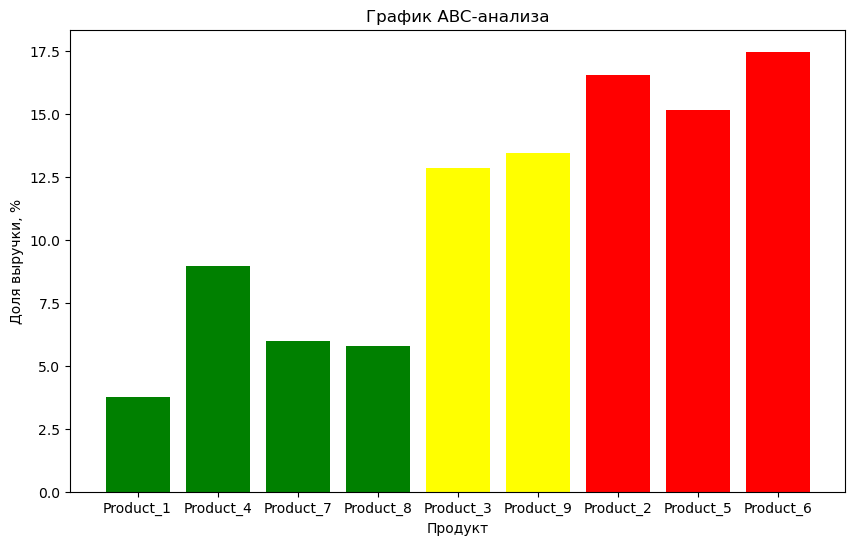

In [113]:
# Сортируем датафрейм по ABC_Class для правильного отображения на графике
total_revenue.sort_values(by='ABC_Class', inplace=True)

# Строим график
plt.figure(figsize=(10, 6))
plt.bar(total_revenue['Product'], total_revenue['RevenuePercentage'] * 100, color=total_revenue['ABC_Class'].map({'A': 'red', 'B': 'yellow', 'C': 'green'}))
plt.xlabel('Продукт')
plt.ylabel('Доля выручки, %')
plt.title('График ABC-анализа')
plt.show()

D:\1. SOFT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\1. SOFT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\1. SOFT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\1. SOFT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


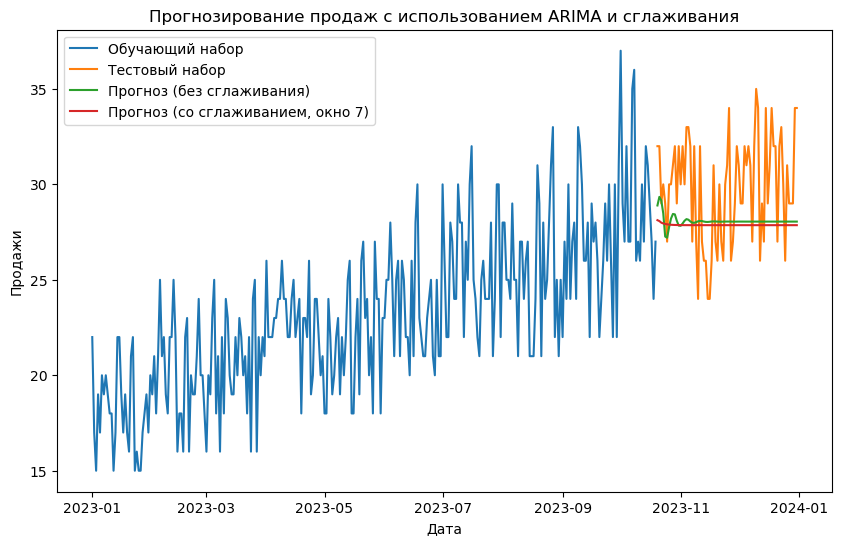

In [115]:
# Сглаживание графика с использованием скользящего среднего
window_size = 7  # Выберите размер окна по вашему усмотрению

# Вычисление скользящего среднего для обучающего набора
rolling_mean = train['Sales'].rolling(window=window_size).mean()

# Обучение модели ARIMA с использованием сглаженных данных
model_smoothed = ARIMA(rolling_mean.dropna(), order=(5, 1, 1))  # Подберите подходящие параметры
fit_model_smoothed = model_smoothed.fit()

# Прогноз на тестовом наборе
predictions_smoothed = fit_model_smoothed.forecast(steps=len(test))

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Sales'], label='Обучающий набор')
plt.plot(test['Date'], test['Sales'], label='Тестовый набор')
plt.plot(test['Date'], predictions, label='Прогноз (без сглаживания)')
plt.plot(test['Date'], predictions_smoothed, label=f'Прогноз (со сглаживанием, окно {window_size})')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.title('Прогнозирование продаж с использованием ARIMA и сглаживания')
plt.legend()
plt.show()


In [118]:
import pandas as pd
import numpy as np

# Загрузка данных из CSV файла
data = pd.read_csv('sales_inventory_orders_data.csv')

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Рассчет сезонных коэффициентов для каждого месяца
monthly_sales = data.groupby(data['Date'].dt.to_period("M"))['Sales'].sum()
seasonal_factors = monthly_sales / monthly_sales.mean()

# Добавление столбца с сезонными коэффициентами в основной датафрейм
data['SeasonalFactor'] = data['Date'].dt.to_period("M").map(seasonal_factors)

# Рассчет корректированных продаж с учетом сезонных коэффициентов
data['SeasonallyAdjustedSales'] = data['Sales'] / data['SeasonalFactor']

# Пример: Рассчет заказов с учетом сезонности
# Здесь вы можете использовать свои правила для расчета заказов, например, EOQ или ROP
# В данном примере просто умножим скорректированные продажи на фактор безопасности
safety_factor = 1.2
data['OrderQuantity'] = data['SeasonallyAdjustedSales'] * safety_factor

# Вывод результата
print(data[['Date', 'Sales', 'SeasonalFactor', 'SeasonallyAdjustedSales', 'OrderQuantity']])


           Date  Sales  SeasonalFactor  SeasonallyAdjustedSales  OrderQuantity
0    2023-01-01     22        0.779683                28.216586      33.859903
1    2023-01-02     17        0.779683                21.803725      26.164470
2    2023-01-03     15        0.779683                19.238581      23.086297
3    2023-01-04     19        0.779683                24.368869      29.242643
4    2023-01-05     17        0.779683                21.803725      26.164470
...         ...    ...             ...                      ...            ...
3280 2023-12-27     29        1.244008                23.311751      27.974102
3281 2023-12-28     32        1.244008                25.723312      30.867974
3282 2023-12-29     17        1.244008                13.665509      16.398611
3283 2023-12-30      0        1.244008                 0.000000       0.000000
3284 2023-12-31     34        1.244008                27.331019      32.797223

[3285 rows x 5 columns]


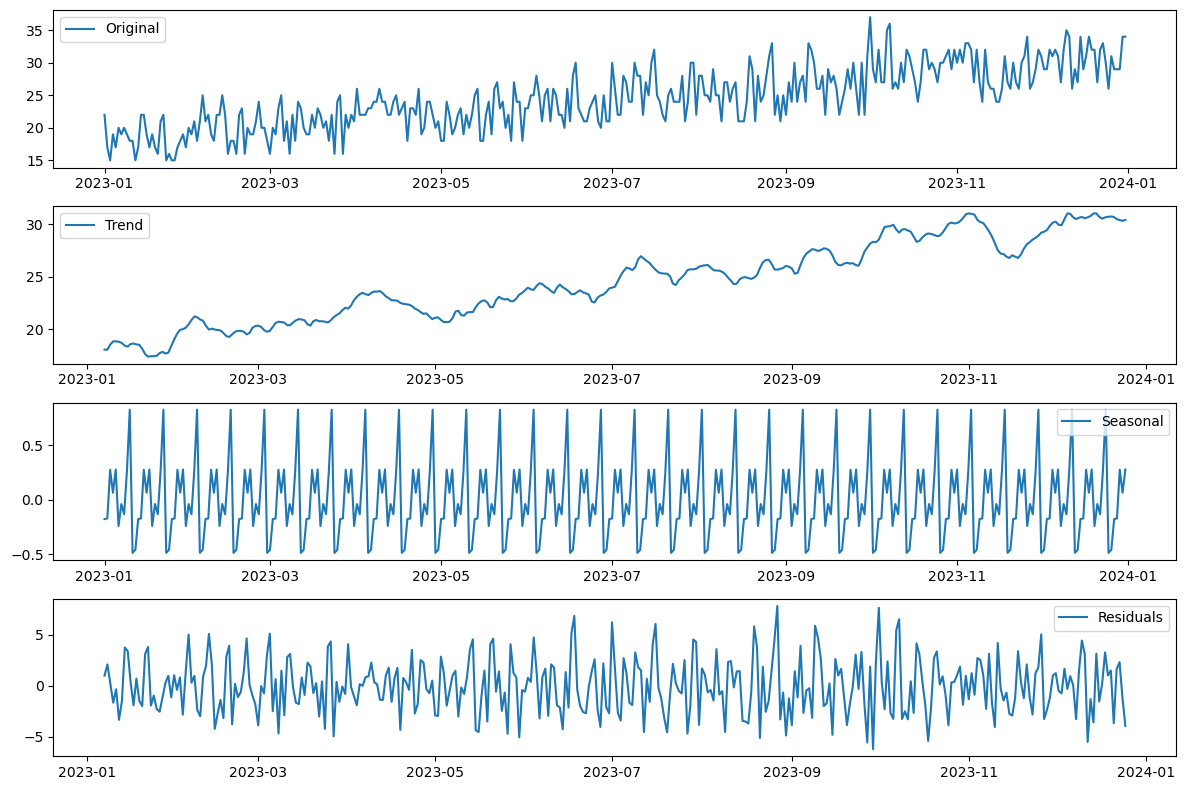

In [119]:
# Assuming 'data' is your DataFrame with the 'Date' and 'Sales' columns
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Decomposition for one product (adjust 'Product_1' as needed)
product_data = data[data['Product'] == 'Product_1']

# Decompose the time series
result = seasonal_decompose(product_data['Sales'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(product_data['Sales'], label='Original')
plt.legend()

# Trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Residuals
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()